In [2]:
"""Regression Analysis and Evaluation - Healthcare Cost Estimation"""

# ------------------------------------------------------------------------------
# Import Core Libraries
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# ------------------------------------------------------------------------------
# Dataset Loading
# ------------------------------------------------------------------------------
data = pd.read_csv("healthcare_dataset.csv")
data.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [4]:
# ------------------------------------------------------------------------------
# Initial Data Preparation
# ------------------------------------------------------------------------------
# Normalize column names
data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")

# Eliminate duplicate entries
data.drop_duplicates(inplace=True)

# Format string fields
clean_columns = ['name', 'gender', 'blood_type', 'medical_condition',
                 'admission_type', 'test_results', 'doctor', 'hospital',
                 'insurance_provider', 'medication']
for field in clean_columns:
    data[field] = data[field].astype(str).str.strip().str.title()

# Limit extreme billing amounts (top 1%)
upper_limit = data['billing_amount'].quantile(0.99)
data = data[data['billing_amount'] <= upper_limit]

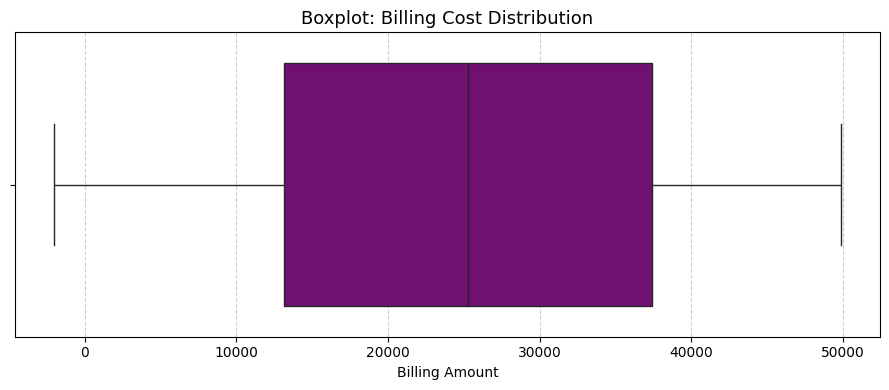

In [5]:
# ------------------------------------------------------------------------------
# Data Visualization
# ------------------------------------------------------------------------------
# Highlighting billing anomalies
plt.figure(figsize=(9, 4))
sns.boxplot(x=data['billing_amount'], color="purple")
plt.title('Boxplot: Billing Cost Distribution', fontsize=13)
plt.xlabel("Billing Amount")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [6]:
# Descriptive metrics
print("Dataset Statistical Summary:")
data.describe()

Dataset Statistical Summary:


,age,billing_amount,room_number
count,54416.000000,54416.000000,54416.000000
mean,51.540870,25292.054081,301.138636
std,19.608549,14055.503426,115.209522
min,13.000000,-2008.492140,101.000000
25%,35.000000,13127.277426,202.000000
50%,52.000000,25284.418338,302.000000
75%,68.000000,37429.149239,401.000000
max,89.000000,49849.329750,500.000000


In [7]:
# ------------------------------------------------------------------------------
# Derived Feature Creation
# ------------------------------------------------------------------------------
# Categorize ages
bins = [0, 20, 40, 60, 100]
labels = ['Teen', 'Adult', 'Midlife', 'Elderly']
data['age_band'] = pd.cut(data['age'], bins=bins, labels=labels)

# ------------------------------------------------------------------------------
# Split Inputs and Target Variable
# ------------------------------------------------------------------------------
input_features = ['age', 'gender', 'medical_condition', 'insurance_provider',
                  'admission_type', 'age_band']
target_variable = data['billing_amount']

X_train, X_test, y_train, y_test = train_test_split(
    data[input_features], target_variable, test_size=0.2, random_state=100)

# ------------------------------------------------------------------------------
# Pipeline Configuration
# ------------------------------------------------------------------------------
categoricals = ['gender', 'medical_condition', 'insurance_provider', 'admission_type', 'age_band']
numericals = ['age']

# Combine transformations
processing_steps = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), numericals),
    ('encode', OneHotEncoder(drop='first'), categoricals)
])

In [8]:
# ------------------------------------------------------------------------------
# Build and Train Models
# ------------------------------------------------------------------------------
model_list = {
    'LinearRegression': Pipeline(steps=[('transform', processing_steps),
                                        ('model', LinearRegression())]),
    'RidgeRegression': Pipeline(steps=[('transform', processing_steps),
                                       ('model', Ridge(alpha=1.0))]),
    'LassoRegression': Pipeline(steps=[('transform', processing_steps),
                                       ('model', Lasso(alpha=0.1))])
}

# ------------------------------------------------------------------------------
# Evaluate Model Performance
# ------------------------------------------------------------------------------
evaluation_report = {}

for model_name, pipeline in model_list.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    mse_val = mean_squared_error(y_test, predictions)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_test, predictions)
    cross_val_r2 = cross_val_score(pipeline, data[input_features], target_variable,
                                   cv=5, scoring='r2').mean()

    evaluation_report[model_name] = {
        'MSE': mse_val,
        'RMSE': rmse_val,
        'R-Squared': r2_val,
        'CV R-Squared': cross_val_r2
    }

In [9]:

# ------------------------------------------------------------------------------
# Final Summary Table
# ------------------------------------------------------------------------------
summary_df = pd.DataFrame(evaluation_report).T
print("\nComparative Model Results:\n")
print(summary_df.round(3))



Comparative Model Results:

                           MSE       RMSE  R-Squared  CV R-Squared
LinearRegression  1.952245e+08  13972.277        0.0          -0.0
RidgeRegression   1.952245e+08  13972.278        0.0          -0.0
LassoRegression   1.952246e+08  13972.278        0.0          -0.0
